# Pistachio Classifier
---
In this notebook Modified ing [my earlier pistachio classifier](https://github.com/Wologman/Computer_Vision/blob/master/pistachio_classifier.ipynb) to use a pre-trained network for feature extraction. In this case I'm starting with densenet121.  The earlier code was adapted from from a multi-class [CFAR10 study problem](https://github.com/Wologman/Udacity_Pytorch/blob/master/convolutional-neural-networks/cifar-cnn/completed_cifar10_cnn_exercise.ipynb).  

There are 54 "bad" nuts, and 66 "good" nuts.  The original images are in colour, jpg format, 1500px wide, 1000px high

<table  style="width:95%">
    <tr>
        <td><img src='images/Good/IMG_20190311_151848.jpg' width="90%" /></td>
        <td><img src='images/Bad/IMG_20190311_150011.jpg' width="90%" /></td>   
    </tr>
    <tr>
        <td style="text-align: center">Good</td>
        <td style="text-align: center">Bad</td>
    </tr>
</table>

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

This step is here because my Dell E6430 doesnt have CUDA enabled GPU, but I may use Colab or get a more fancy notebook some day.  But since this one is so small, it's actually only taking a couple of minutes to train anyway.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available :(  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available :(  Training on CPU ...


---
## Load the Data

The data is sitting in seperate folders, one for 'good' nuts, one for 'bad' ones.

In [2]:
from torchvision import datasets as datasets
from torchvision import transforms as transforms
from torchvision import models as models
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0   # number of subprocesses to use for data loading
batch_size = 18   # how many samples per batch to load for each parameter update

#fraction of full dataset to use as training and validation
train_size = 0.6
valid_size = 0.2

image_size = 224  # needs to be sized for the pre-trained networks

# Note I've made a few changes to the way the tensors are normalised/un-normalised for image display
input_mean = [ 0.485, 0.456, 0.406 ] # mean to be used for normalisation, matching that of the pre-trained images
input_std = [ 0.229, 0.224, 0.225 ] # stdev to be used for normalisation, matching that of the pre-trained images

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    # Normalisation needs to match the data used for the pretrained model.
    transforms.Normalize(input_mean, input_std) 
    ])

# convert for image display, it can be useful to un-normalise the tensor
inv_normalize = transforms.Normalize(
       mean = [-m/s for m, s in zip(input_mean, input_std)],
       std = [1/s for s in input_std]
)

full_dataset = datasets.ImageFolder('images/', transform=transform)

total_images = len(full_dataset)
indices = list(range(total_images))
np.random.shuffle(indices)
train_sp = int(np.floor(train_size * total_images)) # The training-validation split
valid_sp = int(np.floor(valid_size * total_images)) + train_sp # The validation-test split
train_idx, valid_idx, test_idx = indices[:train_sp], indices[train_sp:valid_sp], indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Validation set size: \t', len(valid_idx))
print(' Test set size: \t', len(test_idx))
print(' Total dataset: \t', total_images)


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, 
    sampler = test_sampler, num_workers=num_workers)

# specify the image classes 
#(because the data comes as 0 or 1 in the dataset, just based on order of the directories)

classes = ['Bad', 'Good']
# Would be better to do this more generally using:  full_dataset.class_to_idx

 Training set size: 	 72
 Validation set size: 	 24
 Test set size: 	 24
 Total dataset: 	 120


### Visualize a Batch of Training Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image

def imshow(img):
    img = inv_normalize(img)  # unnormalize the tensor 
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image to numpy

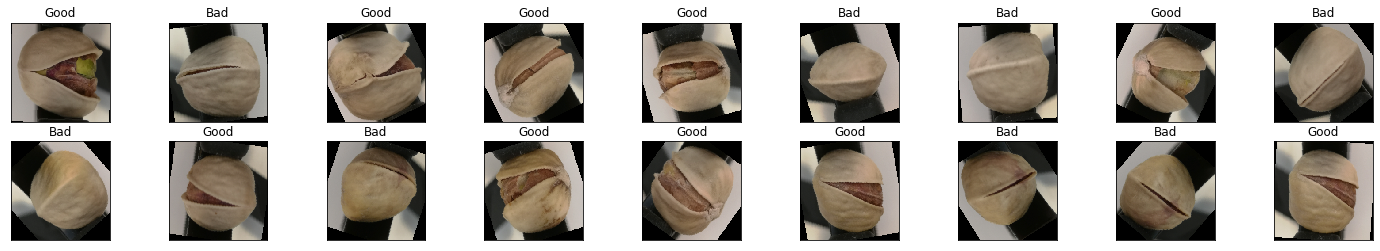

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# 
# The line below appears to be a bug in the original code it gets done in imshow function, 
# but really should be left  as a tensor for the un-normalise step.  

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display one batch of images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])  # may need batch_size//2 for larger 
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

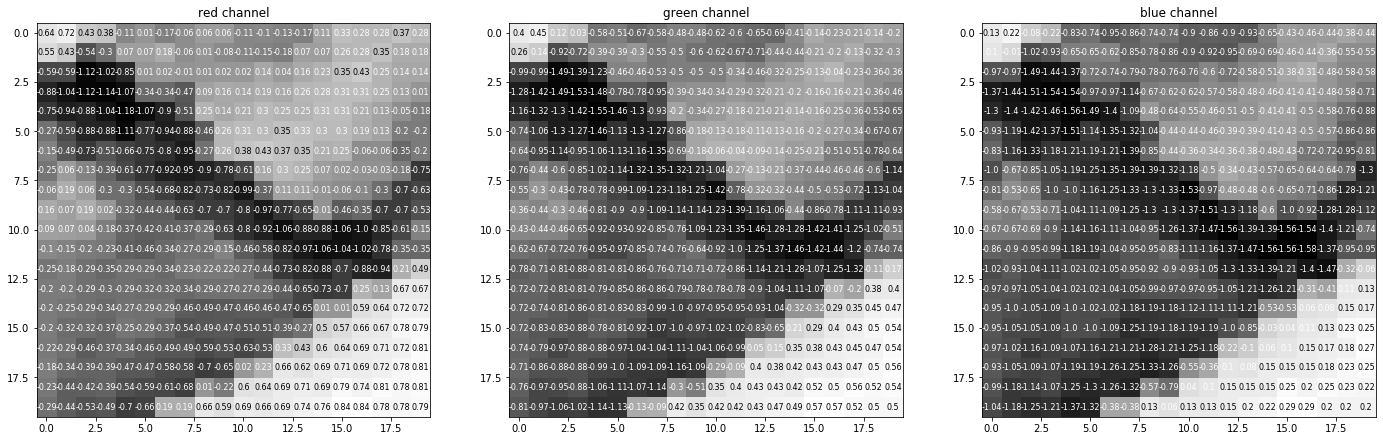

In [5]:
images = images.numpy() 
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (24, 24)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx][100:120, 100:120]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

Just starting out with the architecture I used for CFAR_10

In [6]:
model = models.densenet121(pretrained=True)

In [7]:
from torch import nn

# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#now replace the classifier section of the pre-trained model with a classifier of my choice

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 1)),
                          ('output', nn.Sigmoid())
                          ]))
    
model.classifier = classifier

print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Specify Loss Function and Optimiser

In [8]:
import torch.optim as optim

# specify loss function
criterion = nn.BCELoss() # was nn.CrossEntropyLoss() for multi-class examples

# specify optimiser
optimizer = optim.Adam(model.parameters(), lr=0.01)  # This worked much better than SGD
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

Epoch: 1 	Training Loss: 1.344462 	Validation Loss: 0.328699
Validation loss decreased (inf --> 0.328699).  Saving model ...
Epoch: 2 	Training Loss: 0.332739 	Validation Loss: 0.094139
Validation loss decreased (0.094139 --> 0.020460).  Saving model ...
Epoch: 4 	Training Loss: 0.093149 	Validation Loss: 0.044184
Validation loss decreased (0.020460 --> 0.015919).  Saving model ...
Epoch: 6 	Training Loss: 0.075551 	Validation Loss: 0.045494
Validation loss decreased (0.015919 --> 0.005473).  Saving model ...
Epoch: 8 	Training Loss: 0.072393 	Validation Loss: 0.019603
Epoch: 10 	Training Loss: 0.021009 	Validation Loss: 0.006654
Epoch: 12 	Training Loss: 0.044730 	Validation Loss: 0.005933
Epoch: 14 	Training Loss: 0.134322 	Validation Loss: 0.032255
Epoch: 16 	Training Loss: 0.027003 	Validation Loss: 0.008389
Epoch: 18 	Training Loss: 0.056677 	Validation Loss: 0.003552
Epoch: 20 	Training Loss: 0.030269 	Validation Loss: 0.004682


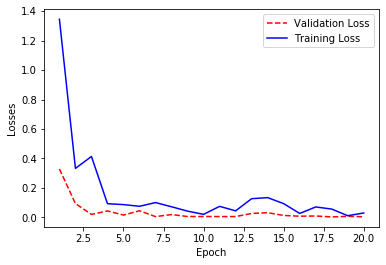

In [9]:
# number of epochs to train the model
import matplotlib.pyplot as plt

n_epochs = 20 # May need to increase this number to train a final model
print_every = 2

valid_loss_min = np.Inf # track change in validation loss

valid_loss_tracker = np.zeros(n_epochs)
train_loss_tracker = np.zeros(n_epochs)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = torch.squeeze(model(data))     # should be a tensor with torch.size [batch_size,1] if all going well
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = torch.squeeze(model(data))
        # calculate the batch loss, the squeeze and float are used to match up the target dimension and dtype
        loss = criterion(output, target.float())  
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # Store in an array, for later plotting
    train_loss_tracker[epoch-1] = train_loss
    valid_loss_tracker[epoch-1] = valid_loss
    
    # print training/validation statistics 
    
    if epoch%print_every == 0 or epoch == 1:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        if epoch%print_every == 1:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
        torch.save(model.state_dict(), 'model_pre_pistachio.pt')
        valid_loss_min = valid_loss

# Plot the training and validation losses
epoch = np.arange(1, n_epochs+1)
plt.plot(epoch, valid_loss_tracker, 'r--', label='Validation Loss') 
plt.plot(epoch, train_loss_tracker, 'b-', label='Training Loss')
plt.legend()
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend()
plt.show()

###  Load the Model with the Lowest Validation Loss

In [10]:
model.load_state_dict(torch.load('model_pre_pistachio.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Use the saved network on some test images.

In [11]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = torch.squeeze(model(data))
    # calculate the batch loss
    loss = criterion(output, target.float())
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output scores to predictions, and store as a pytorch float tensor
    pred = torch.FloatTensor([1 if y > 0.5 else 0 for y in output])
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.024301

Test Accuracy of   Bad: 91% (11/12)
Test Accuracy of  Good: 100% (12/12)

Test Accuracy (Overall): 95% (23/24)


### Visualize Sample Test Results

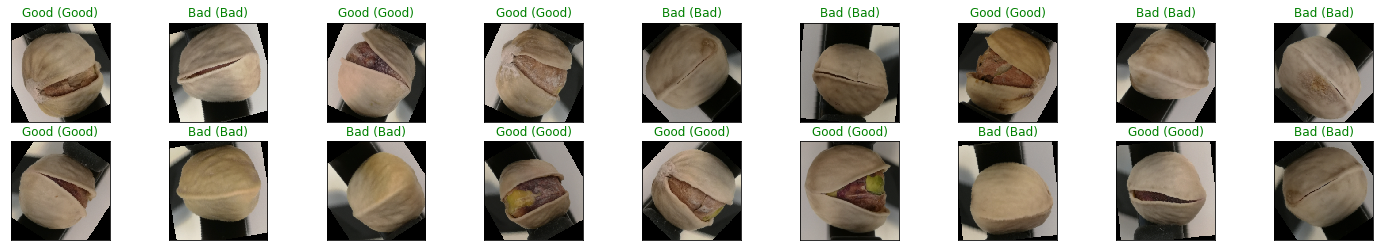

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
#images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)

# convert output scores to predictions
preds = [1 if y > 0.5 else 0 for y in output]

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])   
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
    color=("green" if preds[idx]==labels[idx].item() else "red"))

## Useful learning:


- This performed better, with less training time, fewer epochs and better accuracy than my attempt from scratch.  I'm assuming this is quite fundamental, as the pre-trained network is really good at feature detection, being trained on thousands of (unrelated) images, enabling the CNN layers it to be really deep without over-training compared to my small dataset.

- The nn.sequential as an ordered dict was quite elegant, but not essential.  [Here is the documentation for sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html).  [Also see this post](https://stackoverflow.com/questions/53745454/are-there-any-computational-efficiency-differences-between-nn-functional-vs-nn) Sequential seems to do much the same thing, but hides a bit more under the hood (there is no seperate __init__  declaration for the layers that need updated parameters).  Also I see most people using pre-trained networks just us single layer classifier, so write something like: model.fc = nn.Linear(in_features=512, out_features=2).to(device).   That was a [resnet example](https://www.kaggle.com/lmadhuranga/dog-cat-classifier-pretrained-pytorch).

- I was getting warning messages from pyplot about the image values needing to be clipped.  This went back to the fact that I'd normalised them differently to match the pre-trained network original images, resulting in the images being out of the acceptable range expected by pyplot.  I fixed this by creating a more generalised 'un-normalise' step, so it should work with any normalisation in future.
